## SummariseEmbeddingsOverGroupings
This script:
- Reads in a pickle files which contains a dataframe with one row per sampled image. Each image is associated with a location (lat, lon), a link to the image_file, an embedding, category_scores, and the cluster the image has been assigned to with both 2 and 7 total clusters
- Finds the percentage of images in each LSOA, within each of the clusters
- Finds the mean/min/max embedding within each cluster, within each LSOA
- Saves a pickle file containing a dataframe containing this information

In [32]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

from joblib import Parallel, delayed

def is_missing_embedding(x):
    return isinstance(x, float) and np.isnan(x)

# Aggregation functions
def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)

from functions import *

In [17]:
data_dir = os.path.join("../../../../data/embeddings/")

### Get data

In [18]:
points_data_cache = data_dir + f"embedding_summaries/expanded_gdf_withclustering.pkl"
with open(points_data_cache, "rb") as f:
    expanded_gdf = pickle.load(f)

### Save

In [20]:
# final_df = final_df.merge(lsoa_summary, on = "LSOA21CD")
# file_ending = f'kmeanscluster{k}_resampled1'
# final_df.to_pickle(data_dir + f"embedding_summaries/big_summary_df_{file_ending}.pkl")

# Test model performance 


### Read in IMD data

In [21]:
imd_file = os.path.join("../../../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

### Create a dictionary with random samples of the embedding points
Each key is a sample size between 500 and 20000  
Each item is a dataframe containing a random sample of rows from the dataframe

In [22]:
sample_sizes = [500,1000,2000,3000,4000,5000,6000,7000,10000,12500,15000,20000]
balanced_samples = {}
sampling_status = {}
for n in sample_sizes:
    
    # Create balanced sample
    balanced_samples[n] = balanced_sample(
        expanded_gdf,
        cluster_col,
        n_per_cluster=n,
        random_state=42)
    
    # Record whether each cluster was capped or not
    sampling_status[n] = {
        cluster: (
            "full" if cluster_sizes[cluster] >= n else "capped")
        for cluster in cluster_sizes.index}

### Fit models using subsamples of the data for each cluster, and compare performance
- For each sample size between 500 and 20000:  
    - And each value of k between 2 and 10:
        - Run the model using just the embeddings for the images in each of the clusters

In [28]:
def fit_models_for_k_sample( k, sample_size, df, expanded_gdf, imd, mean_embed, is_missing_embedding,sampling_status):

    # Specifiy the correct column 
    category_column = f"scene_cluster_{k}"
    
    # Create dictionary to store results
    results = {}

    # Define a list of cluster numbers
    categories = np.array(range(1,k+1))

    # 1. Find the mean embedding in each LSOA across images found within each cluster
    # Create a list of dataframes
    # Each entry in the list is a dataframe containing the mean embedding for each cluster 
    per_cluster_dfs = [df[df[category_column] == cat].groupby("LSOA21CD")["embedding"].apply(mean_embed).reset_index()
        .rename(columns={"embedding": f"{cat}_mean"})
        for cat in categories]

    # Convert the list of dataframes into one dataframe, with each colum being the mean embedding in an LSOA for each cluster number
    merged = reduce( lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"),
        per_cluster_dfs)

    # 2. Create a dataframe containing for each LSOA, the overall mean embedding and the mean embedding within each cluster
    final_df = merged

    # 3. Joint to the IMD data
    final_df = pd.merge(final_df, imd[['LSOA21CD', 'imd_rank']], on="LSOA21CD")
    final_df["imd_rerank"] = final_df["imd_rank"].rank(method="first").astype(int)

    # 4. Fit models per cluster 
    # --- For each cluster number 
    for cluster_num in range(1, k + 1):
        print(cluster_num)

        # Don't fit a model if this cluster was capped at this sample size
        if sampling_status[sample_size].get(cluster_num) == "capped":
            results[cluster_num] = np.nan
            continue

        # Specify the column we're focusing on
        column = f"{cluster_num}_mean"
        # Get just the data for this column 
        one_image_type = final_df[["LSOA21CD", column, "imd_rerank"]].copy()
        # Add a column showing that there is no embedding for this LSOA for this cluster number
        one_image_type["missing"] = (one_image_type[column].apply(is_missing_embedding).astype(int))

        # Keep only LSOAs which have an embedding 
        one_image_type = one_image_type[one_image_type["missing"] == 0]

        # Don't run the model if there are less than 5 images
        if len(one_image_type) < 5:
            results[cluster_num] = np.nan
            continue

        # Run the model
        X = np.stack(one_image_type[column].values)
        y = one_image_type["imd_rerank"].values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42 )

        rf = RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=1)

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        results[cluster_num] = r2_score(y_test, y_pred)

    return k, sample_size, results


# Runs the function _fit_models_for_k and saves files along the way
def fit_models_for_k_sample_save(k, sample_size, df, expanded_gdf, imd, mean_embed,
                                 is_missing_embedding, sampling_status,
                                 save_dir="results/"):

    # make sure save_dir exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Run
    k_val, sample_size_val, cluster_results = fit_models_for_k_sample(
        k, sample_size, df, expanded_gdf, imd, mean_embed,
        is_missing_embedding, sampling_status)

    # Save immediately to disk
    file_path = os.path.join(save_dir, f"results_k{k}_n{sample_size}.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(cluster_results, f)

    return k_val, sample_size_val, cluster_results


# Check if results already exist, and load them
# If they don't exist, then create them:

if os.path.exists(data_dir + 'results_dict_plotting.pkl'):
    with open(data_dir + 'results_dict_plotting.pkl', "rb") as f:
        results = pickle.load(f)
else:
    # Create a dictionary to store the results
    results = {}
    k_values= range(2,11)
    n_jobs = 8  # adjust to your machine

    # Run fit_models_for_k_sample_save using parallelisation
    outputs = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(fit_models_for_k_sample_save)(
            k, sample_size, balanced_samples[sample_size],
            expanded_gdf, imd, mean_embed,
            is_missing_embedding, sampling_status)
        for k in k_values
        for sample_size in sample_sizes)

    # Assemble results from outputs
    for k, sample_size, cluster_results in outputs:
        if k not in results:
            results[k] = {}
        for cluster_num, r2 in cluster_results.items():
            results[k].setdefault(cluster_num, {})[sample_size] = r2

    ### Save the results        
    with open(data_dir + 'results_dict_plotting.pkl', "wb") as f:
        pickle.dump(results, f)

In [1]:
# k=5
# sample_size=500
# # Specifiy the correct column 
# category_column = f"scene_cluster_{k}"

# # Create dictionary to store results
# results = {}

# # Define a list of cluster numbers
# categories = np.array(range(1,k+1))

# # 1. Find the mean embedding in each LSOA across images found within each cluster
# # Create a list of dataframes
# # Each entry in the list is a dataframe containing the mean embedding for each cluster 
# per_cluster_dfs = [df[df[category_column] == cat].groupby("LSOA21CD")["embedding"].apply(mean_embed).reset_index()
#     .rename(columns={"embedding": f"{cat}_mean"})
#     for cat in categories]

# # Convert the list of dataframes into one dataframe, with each colum being the mean embedding in an LSOA for each cluster number
# merged = reduce( lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"),
#     per_cluster_dfs)

# # 2. Create a dataframe containing for each LSOA, the overall mean embedding and the mean embedding within each cluster
# final_df = merged

# # 3. Joint to the IMD data
# final_df = pd.merge(final_df, imd[['LSOA21CD', 'imd_rank']], on="LSOA21CD")
# final_df["imd_rerank"] = final_df["imd_rank"].rank(method="first").astype(int)

# # 4. Fit models per cluster 
# # --- For each cluster number 
# for cluster_num in range(1, k + 1):
#     print(cluster_num)
    
#     # Don't fit a model if this cluster was capped at this sample size
#     if sampling_status[sample_size].get(cluster_num) == "capped":
#         results[cluster_num] = np.nan
#         continue
        
#     # Specify the column we're focusing on
#     column = f"{cluster_num}_mean"
#     # Get just the data for this column 
#     one_image_type = final_df[["LSOA21CD", column, "imd_rerank"]].copy()
#     # Add a column showing that there is no embedding for this LSOA for this cluster number
#     one_image_type["missing"] = (one_image_type[column].apply(is_missing_embedding).astype(int))
    
#     # Keep only LSOAs which have an embedding 
#     one_image_type = one_image_type[one_image_type["missing"] == 0]
    
#     # Don't run the model if there are less than 5 images
#     if len(one_image_type) < 5:
#         results[cluster_num] = np.nan
#         continue
    
#     # Run the model
#     X = np.stack(one_image_type[column].values)
#     y = one_image_type["imd_rerank"].values

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=42 )

#     rf = RandomForestRegressor(
#         n_estimators=200,
#         random_state=42,
#         n_jobs=1)

#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)

#     results[cluster_num] = r2_score(y_test, y_pred)

In [26]:
# Forgotten what this does

# for k, sample_size, cluster_results in outputs:
#     if k not in results:
#         results[k] = {}
#     for cluster_num, r2 in cluster_results.items():
#         results[k].setdefault(cluster_num, {})[sample_size] = r2

### Plot the results

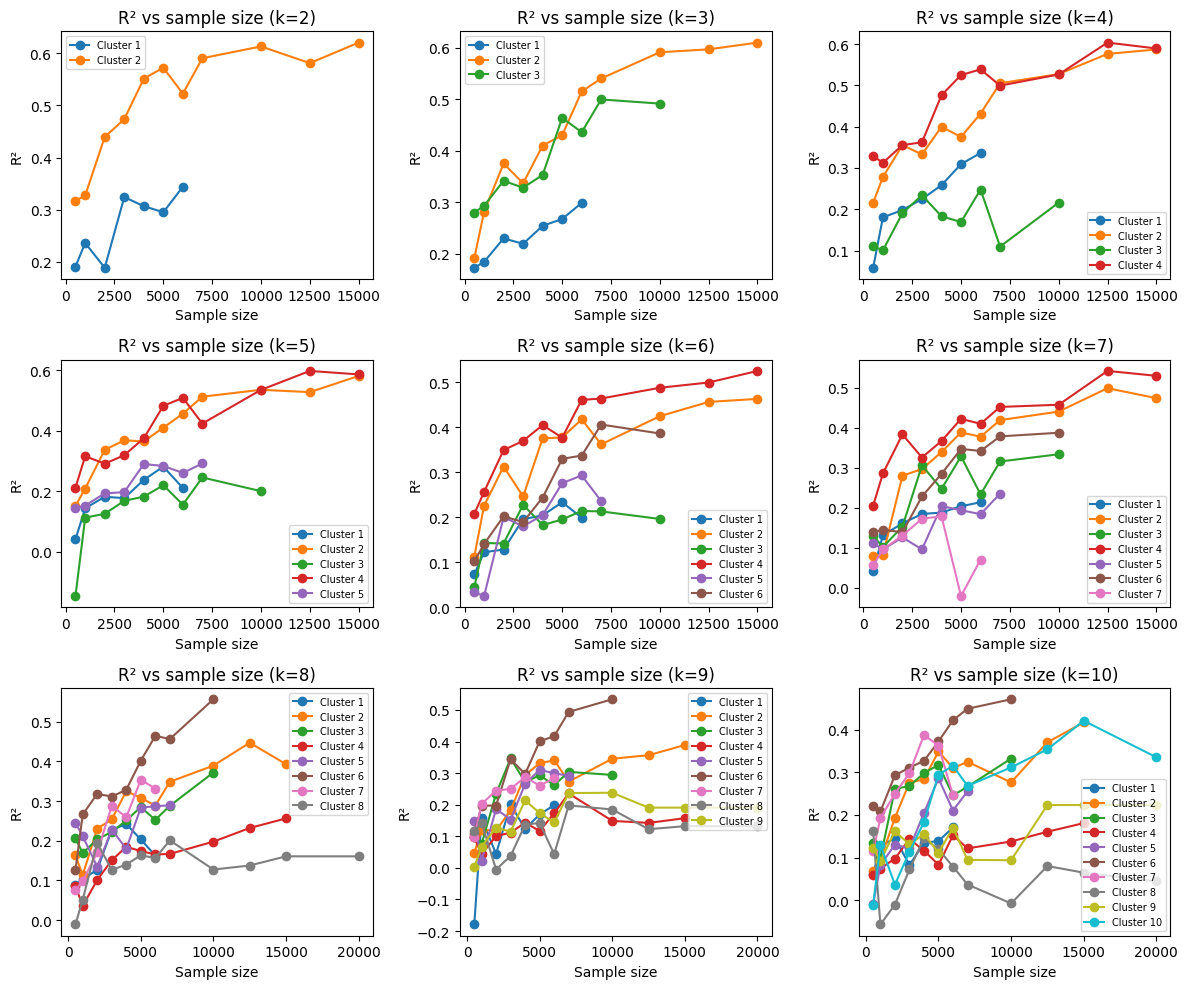

In [28]:
fig,axs=plt.subplots(ncols=3,nrows=3, figsize=(12,10))
axs=axs.flatten()
for ax_num, k in enumerate(k_values):
    for cluster_num, sample_dict in results[k].items():
        x, y = zip(*sorted(sample_dict.items()))
        axs[ax_num].plot(x, y, marker='o', label=f"Cluster {cluster_num}")

    axs[ax_num].set_xlabel("Sample size")
    axs[ax_num].set_ylabel("R²")
    axs[ax_num].set_title(f"R² vs sample size (k={k})")
    axs[ax_num].legend(fontsize=7)
fig.tight_layout()